In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sodapy import Socrata

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
creds_file = open('./creds.json', 'r')
socrata_creds = json.loads(creds_file.read())

In [5]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", socrata_creds['app_token'])

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# Data
---

### DHS Daily Report
Source: https://data.cityofnewyork.us/Social-Services/DHS-Daily-Report/k46n-sa2m

This dataset includes the daily number of families and individuals residing in the Department of Homeless Services (DHS) shelter system and the daily number of families applying to the DHS shelter system.

In [6]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("k46n-sa2m", limit = 10_000);

# Convert to pandas DataFrame
daily_df = pd.DataFrame.from_records(results);

# Functions

In [7]:
def adf(series_to_try):
    """
    a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
    """
    dftest = adfuller(series_to_try)
    result = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return result

def acf_pacf(series_to_plot, n_lag):
    """
    Plot ACF & PACF
    """
    plot_acf(series_to_plot, lags = n_lag);
    plt.ylabel('autocorrelation')
    plt.xlabel('lags');

    plot_pacf(series_to_plot, lags = n_lag);
    plt.ylabel('partial autocorrelation')
    plt.xlabel('lags');

def evaluate(data_to_evaluate, residual):
    
    """
    make residual graphs and print out MSE 
    """

    plt.figure(figsize = (12,5))
    plt.scatter(data_to_evaluate.index, residual)
    plt.title('Residuals')
    plt.axhline(0, color='red')

    return {"mean square error": sum(np.square(residual)) / len(residual)}

# Data Cleaning

The type of all columns is 'object'. `date_of_census` is datetime column and rest of the columns are numerical column. Change the types appropriately.

In [8]:
daily_df['date_of_census'] = daily_df['date_of_census'].apply(lambda x: x.split('T')[0])

daily_df.index = pd.to_datetime(daily_df['date_of_census'], format = "%Y/%m/%d")
daily_df = daily_df.drop('date_of_census', axis = 1)

daily_df = daily_df.apply(pd.to_numeric)

daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2218 entries, 2019-11-18 to 2013-08-21
Data columns (total 12 columns):
total_adults_in_shelter                                    2218 non-null int64
total_children_in_shelter                                  2218 non-null int64
total_individuals_in_shelter                               2218 non-null int64
single_adult_men_in_shelter                                2218 non-null int64
single_adult_women_in_shelter                              2218 non-null int64
total_single_adults_in_shelter                             2218 non-null int64
families_with_children_in_shelter                          2218 non-null int64
adults_in_families_with_children_in_shelter                2218 non-null int64
children_in_families_with_children_in_shelter              2218 non-null int64
total_individuals_in_families_with_children_in_shelter_    2218 non-null int64
adult_families_in_shelter                                  2218 non-null int64
indivi

In [9]:
weekly_df = daily_df.resample('W').mean()

In [10]:
train, test = train_test_split(weekly_df['total_individuals_in_shelter'],
                               test_size = 0.25,
                               shuffle = False,
                               random_state = 274)

In [ ]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in [3, 4, 51, 52]: 
                # testing monthly seasonality with 3,4
                # testing yearly seaonailty with 51, 52
                try:
                    print(f'Attempting to fit SARIMAX(0,1,0)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = train,
                                      order = (0, 1, 0),              # (p, d, q)
                                      seasonal_order = (P, D, Q, S))  # (P, D, Q, S) 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=test.index[0], # X_test data range
                                          end=test.index[-1])

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 0)x({P},{D},{Q},{S}) is: {mean_squared_error(test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(test, preds):
                        best_mse = mean_squared_error(test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 1, 0)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

Attempting to fit SARIMAX(0,1,0)x(0,0,0,3)
The MSE for (0, 1, 0)x(0,0,0,3) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,4)
The MSE for (0, 1, 0)x(0,0,0,4) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,51)
The MSE for (0, 1, 0)x(0,0,0,51) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,0,0,52)
The MSE for (0, 1, 0)x(0,0,0,52) is: 1020947.7733325039
Attempting to fit SARIMAX(0,1,0)x(0,1,0,3)
The MSE for (0, 1, 0)x(0,1,0,3) is: 10461508.332841933
Attempting to fit SARIMAX(0,1,0)x(0,1,0,4)
The MSE for (0, 1, 0)x(0,1,0,4) is: 16265924.562282033
Attempting to fit SARIMAX(0,1,0)x(0,1,0,51)
The MSE for (0, 1, 0)x(0,1,0,51) is: 2034330.5033528344
Attempting to fit SARIMAX(0,1,0)x(0,1,0,52)
The MSE for (0, 1, 0)x(0,1,0,52) is: 991310.4527389193
Attempting to fit SARIMAX(0,1,0)x(0,2,0,3)
The MSE for (0, 1, 0)x(0,2,0,3) is: 3732390278.948957
Attempting to fit SARIMAX(0,1,0)x(0,2,0,4)
The MSE for (0, 1, 0)x(0,2,0,4) is: 77500218.85893044
Attempting to f

245042.42024590212


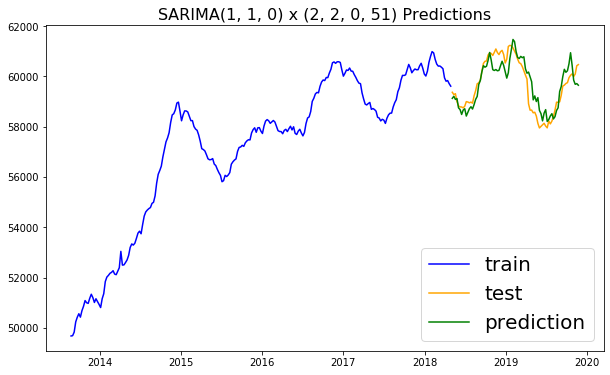

In [11]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 51) model.

sarima = SARIMAX(endog = train,
                 order = (0, 1, 0),              # (p, d, q)
                 seasonal_order = (2, 2, 0, 52) ) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1])
# Evaluate predictions.
print(mean_squared_error(test, preds))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train, color = 'blue', label = 'train')
plt.plot(test, color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 51) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

In [12]:
resids = list(test - preds)

{'mean square error': 245042.42024590206}

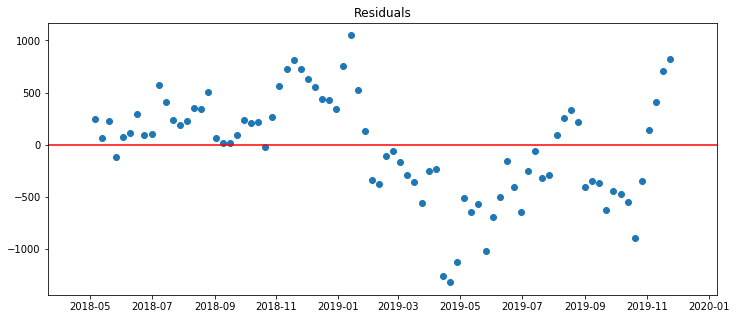

In [13]:
evaluate(test, resids)

# SARIMAX

In [69]:
housing_df = pd.read_csv("./homeless/nyc_housing_112019.csv")

In [70]:
# turn housing_df into timesereis data
housing_df.index = pd.to_datetime(housing_df['project_start_date'], format = "%Y/%m/%d")

In [71]:
housing_df = housing_df.drop("project_start_date", axis = 1)

In [72]:
housing_df.shape

(4204, 9)

- `reporting_construction_type`: Preserve counts might be important?
- `extended_affordability_status`: The Extended Affordability Only field indicates whether the project is considered to be Extended Affordability. An extended affordability project involves no construction, but secures an extended or new regulatory agreement. All extended affordability projects have a ‘reporting construction type’ of ‘preservation.’
- `extremely_low_income_units`: Extremely Low Income Units are units with rents that are affordable to households earning 0 to 30% of the area median income (AMI).
- `very_low_income_units`: Very Low Income Units are units with rents that are affordable to households earning 31 to 50% of the area median income (AMI).
- `low_income_units`: Low Income Units are units with rents that are affordable to households earning 51 to 80% of the area median income (AMI).
- `moderate_income_units`: Moderate Income Units are units with rents that are affordable to households earning 81 to 120% of the area median income (AMI).
- `middle_income_units`: Middle Income Units are units with rents that are affordable to households earning 121 to 165% of the area median income (AMI).
- `all_counted_units`: The Counted Units field indicates the total number of affordable, regulated units counted towards the Housing New York plan that are in the building.
- `total_units`: The Total Units field indicates the total number of units, affordable and market rate, in each building.

In [73]:
# turn housing_df into weekly times series data
w_housing = housing_df.resample('W').mean()

In [74]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None):
    
    """
    from lecture 9.02"""
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label = str(col))
#         plt.title(str(col), fontsize=26)
        
    # Generate title and labels.
    
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);
    plt.legend()

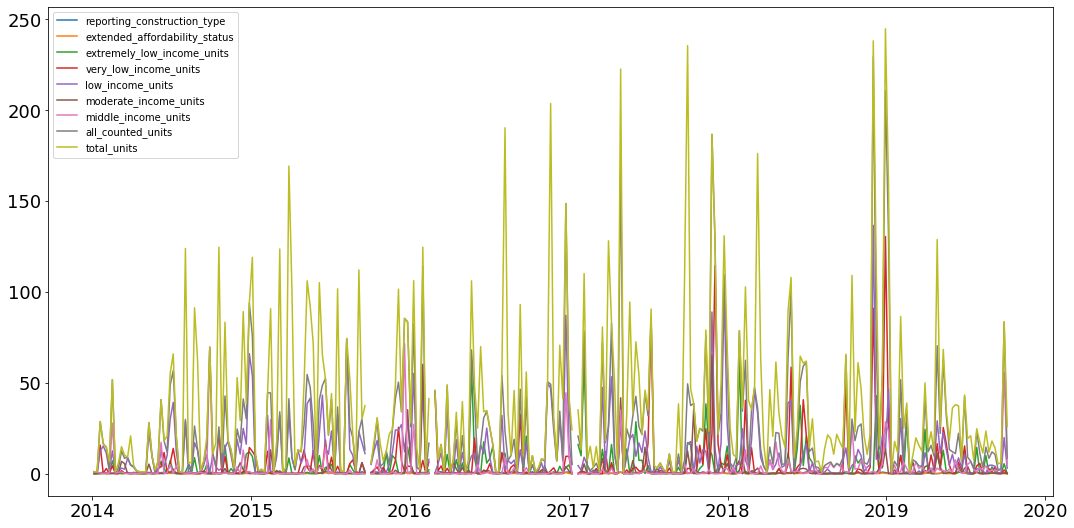

In [86]:
n = range(len(w_housing.columns))

plot_series(w_housing , cols = w_housing.columns[n])

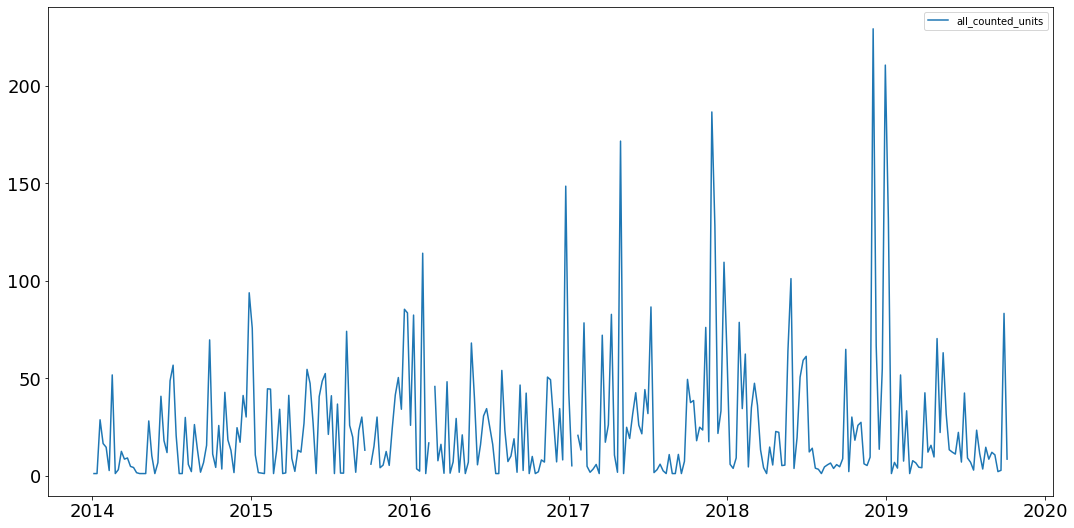

In [76]:
plot_series(w_housing , cols = ['all_counted_units'])

- It seems like peaks appear in simliar places. `all_counted_units` however seems to have the biggest peaks. Therefore, `all_counted_units` column will be tested in SARIMAX model

In [77]:
daily_housing = housing_df.resample('D').sum()

In [78]:
daily_comb = daily_df.join(daily_housing)

### Using all housing data by turning unavailable data = 0

In [79]:
weekly_comb = daily_comb.resample('W').mean().fillna(0)

In [121]:
weekly_comb

,reporting_construction_type,extended_affordability_status,extremely_low_income_units,very_low_income_units,low_income_units,moderate_income_units,middle_income_units,all_counted_units,total_units,total_adults_in_shelter,...,total_individuals_in_shelter,single_adult_men_in_shelter,single_adult_women_in_shelter,total_single_adults_in_shelter,families_with_children_in_shelter,adults_in_families_with_children_in_shelter,children_in_families_with_children_in_shelter,total_individuals_in_families_with_children_in_shelter_,adult_families_in_shelter,individuals_in_adult_families_in_shelter
project_start_date,,,,,,,,,,,,,,,,,,,,,
2014-01-05,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,28964.000000,...,50956.000000,7343.000000,2684.666667,10027.666667,10514.333333,14963.333333,21992.000000,36955.333333,1874.333333,3973.000000
2014-01-12,0.285714,0.000000,0.000000,0.000000,0.142857,0.000000,0.285714,0.428571,0.428571,29086.142857,...,51157.571429,7387.714286,2719.428571,10107.142857,10539.714286,15002.857143,22071.428571,37074.285714,1874.142857,3976.142857
2014-01-19,0.571429,0.000000,0.000000,22.285714,17.571429,0.000000,0.428571,40.857143,40.857143,29179.000000,...,51355.857143,7375.000000,2759.571429,10134.571429,10596.714286,15075.571429,22176.857143,37252.428571,1873.142857,3968.857143
2014-01-26,1.142857,0.142857,0.000000,0.142857,26.000000,1.428571,0.142857,28.142857,28.142857,29497.714286,...,51840.000000,7505.714286,2797.285714,10303.000000,10672.714286,15188.571429,22342.285714,37530.857143,1892.714286,4006.142857
2014-02-02,0.428571,0.000000,0.000000,4.000000,16.142857,0.000000,0.428571,20.714286,20.714286,29542.857143,...,52017.857143,7478.857143,2775.714286,10254.571429,10735.857143,15287.571429,22475.000000,37762.571429,1891.285714,4000.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-08,0.857143,0.000000,1.571429,5.142857,5.714286,0.142857,2.142857,15.142857,20.142857,37806.285714,...,59242.714286,11821.142857,4456.571429,16277.714286,12141.142857,16225.714286,21436.428571,37662.142857,2508.714286,5302.857143
2019-09-15,0.142857,0.000000,0.142857,0.000000,0.000000,0.000000,0.714286,0.857143,2.285714,38025.571429,...,59609.428571,11877.571429,4505.000000,16382.571429,12223.714286,16330.714286,21583.857143,37914.571429,2513.285714,5312.285714
2019-09-22,0.142857,0.000000,0.000000,0.000000,0.285714,0.000000,0.857143,1.142857,2.571429,38036.714286,...,59647.000000,11883.428571,4542.142857,16425.571429,12212.142857,16322.571429,21610.285714,37932.857143,2501.857143,5288.571429


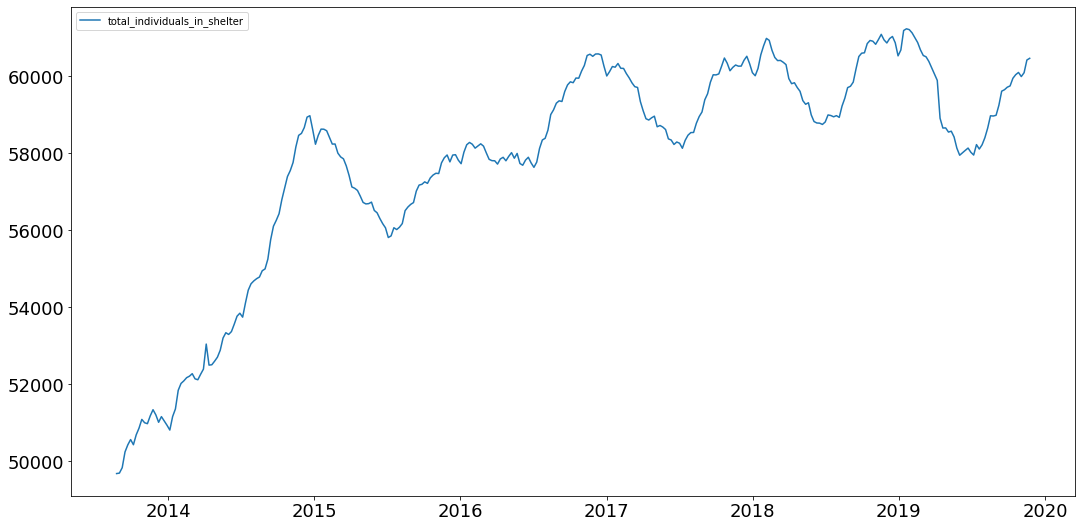

In [91]:
plot_series(weekly_comb , cols = ['total_individuals_in_shelter'])

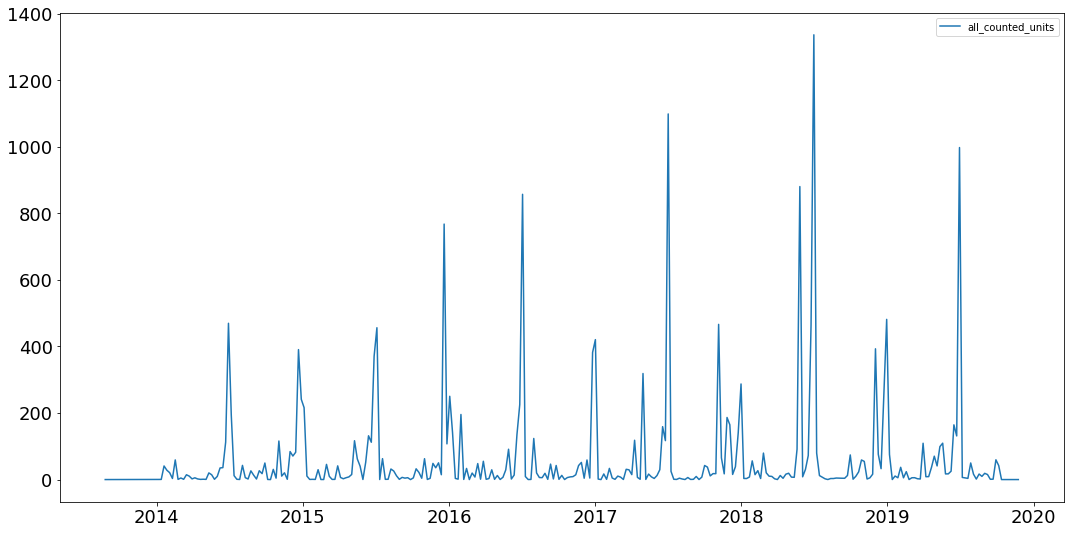

In [89]:
plot_series(weekly_comb , cols = ['all_counted_units'])

In [82]:
train, test = train_test_split(weekly_comb[['total_individuals_in_shelter', 'all_counted_units']],
                               test_size = 0.25,
                               shuffle = False,
                               random_state = 274)

In [83]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 52) model.

sarima = SARIMAX(endog = train.iloc[:,0],
                 exog = train.iloc[:,1], 
                 order = (0, 1, 0),
                 seasonal_order = (2, 2, 0, 52)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1],
                      exog = test.iloc[:,[1]])

243289.4727536189
493.2438268783695


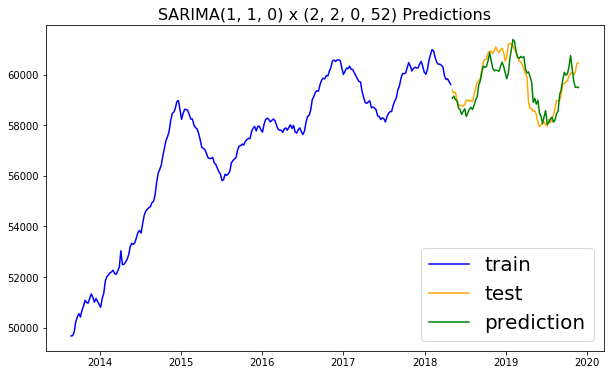

In [87]:
# Evaluate predictions.
print(mean_squared_error(test.iloc[:,0], preds))
print(np.sqrt(mean_squared_error(test.iloc[:,0], preds)))
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train.iloc[:,0], color = 'blue', label = 'train')
plt.plot(test.iloc[:,0], color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 52) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();

### Not using unavailable housing data

In [92]:
daily_comb = daily_housing.join(daily_df)

In [118]:
weekly_comb = daily_comb.resample('W').mean()

In [119]:
weekly_comb.to_csv('./homeless/weekly_comb.csv')

In [101]:
train, test = train_test_split(weekly_comb[['total_individuals_in_shelter', 'all_counted_units']],
                               test_size = 0.25,
                               shuffle = False,
                               random_state = 274)

In [116]:
# Fit a SARIMA(0, 1, 0) x (2, 2, 0, 52) model.

sarima = SARIMAX(endog = train.iloc[:,0],
                 exog = train.iloc[:,1], 
                 order = (0, 1, 0),
                 seasonal_order = (2, 2, 0, 51)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=test.index[0], # X_test data range
                      end=test.index[-1],
                      exog = test.iloc[:,[1]])

241907.9406093071
491.841377488014


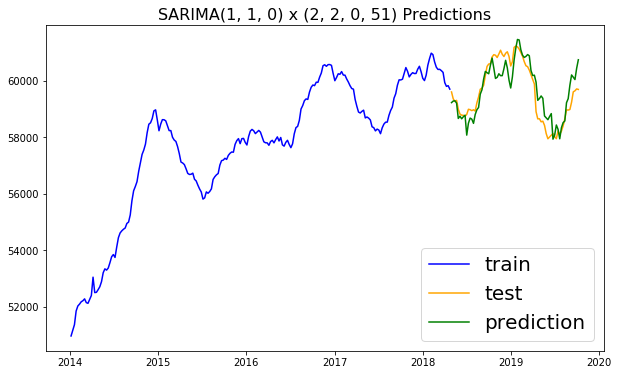

In [117]:
# Evaluate predictions.
print(mean_squared_error(test.iloc[:,0], preds))
print(np.sqrt(mean_squared_error(test.iloc[:,0], preds)))
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train.iloc[:,0], color = 'blue', label = 'train')
plt.plot(test.iloc[:,0], color = 'orange', label = 'test')
plt.plot(preds, color = 'green', label = 'prediction')
plt.title(label = 'SARIMA(1, 1, 0) x (2, 2, 0, 51) Predictions', fontsize=16)
plt.legend(fontsize = 20)
plt.show();